In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings

import sys
from pyprojroot import here
sys.path.append("../..") 
from os.path import exists

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import geopandas as gpd
import xarray as xr
import pathlib

from laos_gggi.replication_data import create_replication_data
from laos_gggi.plotting import plotting_function_damages 
from laos_gggi.model import add_data
from laos_gggi.plotting import configure_plot_style

from laos_gggi.sample import sample_or_load
from sklearn.preprocessing import StandardScaler as Standardize

from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data

In [3]:
# Set random seed
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

# Loading and preparing data 

In [4]:
# Select SEA countries
laos_neighboors = [
    "KHM",  # Cambodia
    "THA",  # Thailand
    "LAO",  # Laos
    "VNM",  # Vietnam
]

In [5]:
# Configure pytensir floats
floatX = pytensor.config.floatX


# Load idatas
event_idata = az.from_netcdf("model_closest_full_long.idata")
damage_idata = az.from_netcdf("damages_model3.idata")

#Rename ISO dimension to avoid conflicts merging
damage_idata =damage_idata.rename({"ISO": "ISO_damage",
                                                   "country_effect": "country_effect_damage"})

#Merge posteriors
merged_posteriors = xr.merge([event_idata.sel(ISO = laos_neighboors).posterior,
                              damage_idata.posterior])

In [6]:
# Load maps
world = load_shapefile('world')

# Define maps
sea_map = world.query('ISO_A3 in @laos_neighboors')
laos_map = world.query('ISO_A3 == "LAO"')

### Events data

In [7]:
grid_cols =  [ 'long', 'lat', 'distance_to_river', 'log_distance_to_river', 'log_distance_to_coastline', 'geometry', 'ISO',
'log_distance_to_river__standardized', 'log_distance_to_coastline__standardized' , 'log_distance_to_river__standardized__squared',
'log_distance_to_coastline__standardized__squared']

In [8]:
#Load event data sets
sea_point_grid = pd.read_csv(here("data/sea_point_grid.csv"),index_col=0  )[grid_cols]
laos_point_grid = pd.read_csv(here("data/laos_point_grid.csv"),index_col=0 )[grid_cols]
sea_df = pd.read_csv(here("data/sea.csv"),index_col=0 )
lao_df = pd.read_csv(here("data/lao.csv"),index_col=0 )
sea_df_stand = pd.read_csv(here("data/sea_df_stand.csv"),index_col=0 )
lao_df_stand = pd.read_csv(here("data/lao_df_stand.csv"),index_col=0 )

# Load predictions
predictions = pd.read_csv(here("data/climate_forecast.csv")).rename(columns = {"time": "Start_Year"})


# Load damage df
damage_df_stand = pd.read_csv(here("data/damage_df_stand.csv"),index_col =0 )
damage_df_stand["Population"] = damage_df_stand["Population"] * 1e6

# Load IPCC data
ipcc_preds = pd.read_csv(here("data/ippc_projections.csv"), index_col=  "Year").head(14)

In [9]:
# create predictions_ISO
predictions["ISO"] = "LAO"

# Select years of interest
prediction_years = ["2026-01-01", "2030-01-01", "2040-01-01", "2050-01-01", "2070-01-01"]
predictions_short = predictions.query('Start_Year in @prediction_years')

In [10]:
# create grid point number
laos_point_grid = laos_point_grid.reset_index().rename(columns = {"index": "point_number" })

# merge grid and predictions
pred_df = pd.merge(laos_point_grid ,predictions_short, left_on= "ISO", right_on= "ISO", how = "left" )

In [11]:
# Create population density
pred_df["population_density"] = pred_df["Population"] / 236800 # Laos area in squared km hardcoded

# Calculate logs
pred_df["log_population_density"] = np.log(pred_df["population_density"])
pred_df["log_gdp_per_cap"] = np.log(pred_df["gdp_per_cap"])

In [12]:
# Define features
event_features = ['lat', 'long', 'log_distance_to_river__standardized', "log_distance_to_coastline__standardized",
"log_distance_to_river__standardized__squared", "log_distance_to_coastline__standardized__squared",
 "Population__standardized", "co2__standardized", "precip_deviation__standardized", "dev_ocean_temp__standardized", 
'log_population_density__standardized','log_gdp_per_cap__standardized', 
"log_gdp_per_cap__standardized__squared", "log_population_density__standardized__squared" ]

distance_features = event_features[0:6]
time_varying_features = event_features[6:]
time_varying_features_base =[x[ :-14] for x in event_features[6:12]]


### Damage data

In [13]:
# Set event features
damage_features_base = ['Population',
 'log_population_density',
 'log_gdp_per_cap',
 'dev_ocean_temp',
 'co2',
 'precip_deviation',]

damage_features_d = ["d_" + x for x in  damage_features_base]

damage_features_d_stand = [x +"__standardized" for x in damage_features_d]

for feature, d_feature in zip(damage_features_base,  damage_features_d ):
    pred_df[d_feature] = pred_df[feature]
    damage_df_stand[d_feature] = damage_df_stand[feature]


### Standardize data

In [14]:
################## standardize events data ##################
# Select cols to stand
cols_to_stand = ['Population', 'dev_ocean_temp',
                 'co2', 'log_population_density', 'log_gdp_per_cap',
       'precip_deviation',]

cols_to_stand_stand = [x + "__standardized" for x in  cols_to_stand]

cols_not_stand = ['ISO' , 'Start_Year', 'lat', 'long', 'geometry', 'point_number', 'log_distance_to_river__standardized',
       'log_distance_to_coastline__standardized', 'log_distance_to_river__standardized__squared','log_distance_to_coastline__standardized__squared']


#Train transformers
transformer_stand_ =  Standardize().fit(sea_df[cols_to_stand] )

# standardize pred_df
pred_df_stand = transformer_stand_.transform(pred_df[cols_to_stand] )
pred_df_stand = pd.DataFrame(pred_df_stand, columns =cols_to_stand_stand )
pred_df_stand = pd.merge(pred_df_stand, pred_df[cols_not_stand], left_index=True, right_index= True, how = "left" )

In [15]:
################## standardize damage data ##################
# Select cols to stand
cols_to_stand_2 = damage_features_d.copy()

cols_to_stand_stand_2 = damage_features_d_stand.copy()

#Train transformers
transformer_stand__damage =  Standardize().fit(damage_df_stand[cols_to_stand_2] )

# standardize pred_df
pred_df_stand_damage = transformer_stand__damage.transform(pred_df[cols_to_stand_2] )
pred_df_stand_damage = pd.DataFrame(pred_df_stand_damage, columns =cols_to_stand_stand_2 )
pred_df_stand = pd.merge(pred_df_stand, pred_df_stand_damage, left_index=True, right_index= True, how = "left" )

In [16]:
# Calculate logs squared
pred_df_stand["log_gdp_per_cap__standardized__squared"] = pred_df_stand["log_gdp_per_cap__standardized"] **2
pred_df_stand["log_population_density__standardized__squared"] = pred_df_stand["log_population_density__standardized"] **2
pred_df_stand["d_log_gdp_per_cap__standardized__squared"] = pred_df_stand["d_log_gdp_per_cap__standardized"] **2


### Center Laos lat-long using SEA data

In [17]:
# Compute sea center
sea_center =  {}

# center Laos values
for x in ["lat", "long"]:
    sea_center[x] = (sea_df[x].max() + sea_df[x].min()) /  2
    pred_df_stand[x + "_centered"] = pred_df_stand[x] - sea_center[x]

In [18]:
### Create pred_df_stand_dict for several years
pred_df_stand_dict = {}

for year in pred_df_stand["Start_Year"].unique():
    pred_df_stand_dict[year] = pred_df_stand.query('Start_Year == @year')

In [19]:
cols_1 = ['log_gdp_per_cap', 'precip_deviation',
       'distance_to_coastline', 'log_distance_to_river',
       'log_distance_to_coastline', 'log_population_density', 'co2',
       'dev_ocean_temp', 'lat', 'distance_to_river',
       'long__standardized', 'Population__standardized',
       'real_gdp__standardized', 'log_gdp_per_cap__standardized',
       'precip_deviation__standardized', 'distance_to_coastline__standardized',
       'log_distance_to_river__standardized',
       'log_distance_to_coastline__standardized',
       'log_population_density__standardized', 'co2__standardized',
       'dev_ocean_temp__standardized', 'lat__standardized',
       'distance_to_river__standardized',
       'log_gdp_per_cap__standardized__squared',
       'log_population_density__standardized__squared',
       'log_distance_to_river__standardized__squared',
       'log_distance_to_coastline__standardized__squared']

# Set coords

In [20]:
# gp features
gp_features = ["lat", "long"]

# damage features
damage_features = damage_features_d_stand + ["d_log_gdp_per_cap__standardized__squared"]

# Event features
event_features = ['log_distance_to_river__standardized',
 'log_distance_to_coastline__standardized',
 'Population__standardized',
 'co2__standardized',
 'precip_deviation__standardized',
 'dev_ocean_temp__standardized',
 'log_population_density__standardized',
 'log_gdp_per_cap__standardized',
 'log_gdp_per_cap__standardized__squared',
 'log_population_density__standardized__squared',
 'log_distance_to_river__standardized__squared',
 'log_distance_to_coastline__standardized__squared']

In [21]:
# Define event coords
is_disaster_idx_events , is_disaster_events  = pd.factorize(sea_df_stand["is_disaster"])
ISO_idx_events , ISO_events  = pd.factorize(sea_df_stand["ISO"]) 
obs_idx_events  = sea_df_stand.index

#Creating idx
xr_idx_events  = xr.Coordinates.from_pandas_multiindex(sea_df_stand.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
event_coords = {"is_disaster" : is_disaster_events,
        "obs_idx": obs_idx_events,
        "ISO": ISO_events,
        "feature": event_features,
        "gp_feature":gp_features }


In [22]:
# Define damage coords
ISO_idx_damage, ISO_damage =  pd.factorize(damage_df_stand["ISO"])
coords_damage = {
    'ISO':ISO_damage,
    'obs_idx':damage_df_stand.index,
    'feature': damage_features
        }    

xr_idx_damage = xr.Coordinates.from_pandas_multiindex(damage_df_stand.set_index(['ISO', 'year']).index, 'obs_idx')


In [23]:
# Prediction coords
obs_idx = pred_df_stand_dict["2026-01-01"]["point_number"]


gp_features = ["lat", "long"]


# Rebuild ISO_idx_sea
ISO_idx, ISO = pd.factorize(sea_df["ISO"]) 

ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_laos =  pred_df_stand_dict["2026-01-01"].ISO.map(ISO_to_idx.get)

years = pred_df_stand["Start_Year"].unique()

# ISO damage
ISO_damage_idx, ISO_damage =  pd.factorize(damage_df_stand["ISO"])
ISO_to_idx_2 = {name: idx for idx, name in enumerate(ISO_damage)}
ISO_damage_idx_laos =  pred_df_stand_dict["2026-01-01"].ISO.map(ISO_to_idx_2.get)

# 


#Set coords_predictions
coords_predictions = {
    # "is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "distance_features": distance_features,
        "time_varying_features" : time_varying_features,
        "gp_feature":gp_features,
        "ISO_damage": ISO_damage ,
        "damage_features": damage_features,
        "event_features": event_features,
        "year":years
                     }

# Compute the curves

In [24]:
# Compute center function
def compute_center(X):
    return (pt.max(X, axis=0) + pt.min(X, axis=0)).eval() / 2

In [25]:
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data

damage_curves_plot = {}

for year in years:
    
    with pm.Model(coords=coords_predictions) as damage_curves_plot[year]:
        ####################################Events model####################################
        # Set data
        event_features_data = add_data(features= event_features ,  target = None, df =  pred_df_stand_dict[year],
                                   dims=['obs_idx', 'features'])
        X_gp = pm.Data("X_gp",  pred_df_stand_dict[year][["lat_centered", "long_centered"]].astype(floatX), dims=['obs_idx', 'gp_feature'])
    
        #Flat variables
        country_effect = pm.Flat("country_effect", dims = ["ISO"])    
        beta = pm.Flat("beta", dims = ["event_features"])
        
        # HSGP component
        eta = pm.Flat("eta")
        ell = pm.Flat("ell", dims=["gp_feature"])
        cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    
        m0, m1, c = 35, 35, 1.5
        gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
        gp._X_center = compute_center( pred_df_stand_dict[year][["lat_centered", "long_centered"]].values.astype(floatX))
    
        phi, sqrt_psd = gp.prior_linearized(X=X_gp)
    
        basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)
    
        HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    
        # Event model components
        event_features_component = pm.Deterministic('event_features_component', 
                                                    event_features_data @ beta, dims=['obs_idx'])

        event_features_component_inv_logit = pm.Deterministic('event_features_component_inv_logit', 
                                           pm.math.invlogit(event_features_component))

        HSGP_component_inv_logit = pm.Deterministic('HSGP_component_inv_logit', 
                                                   pm.math.invlogit(HSGP_component))
        
        logit_p = pm.Deterministic('logit_p', country_effect[ISO_idx_laos] + event_features_component 
                                   + HSGP_component, dims=['obs_idx'])
        event_prob_y_hat = pm.Deterministic('event_prob_y_hat', pm.math.invlogit(logit_p), dims=['obs_idx'])
    
        ####################################Damages model####################################
        # Set data
        damage_x_data = pm.Data("damage_x_data",   pred_df_stand_dict[year][damage_features], dims=['obs_idx', 'damage_features'])
    
        # Set flats
        country_effect_damage = pm.Flat("country_effect_damage", dims = ["ISO_damage"])
        betas_damage = pm.Flat("betas_damage", dims = ["damage_features"])
        sigma_damage = pm.Flat("sigma_damage")
    
        #Damage model components
        mu =  country_effect_damage[ISO_damage_idx_laos] + damage_x_data @ betas_damage
       
        ln_damage_millions = pm.Normal("ln_damage_millions", mu = mu, sigma = sigma_damage , dims = ["obs_idx"])
    
        damage_millions = pm.Deterministic("damage_millions", pm.math.exp(ln_damage_millions), dims=['obs_idx'])
    
        # # #################################### Damage curves ####################################
        damages_curves = pm.Deterministic("damages_curves", damage_millions * event_prob_y_hat, dims=['obs_idx'])

In [26]:
# Sample predictions
idata_plot_point = {}
for year in years:
    if exists(here(f"notebooks/geo_damage_model/damage_curves_base_{year}.idata")):
        idata_plot_point[year] = az.from_netcdf(here(f"notebooks/geo_damage_model/damage_curves_base_{year}.idata"))

In [26]:
# Sample predictions
idata_plot_point = {}
for year in years:
    if exists(here(f"notebooks/geo_damage_model/damage_curves_base_{year}.idata")):
        idata_plot_point[year] = az.from_netcdf(here(f"notebooks/geo_damage_model/damage_curves_base_{year}.idata"))
                                                
    else:                                  
        with freeze_dims_and_data(damage_curves_plot[year] ):
            idata_plot_point[year] = pm.sample_posterior_predictive(merged_posteriors , extend_inferencedata=False, 
                                                              compile_kwargs={'mode':'JAX'},
                                                        var_names=[
                                                                  'event_features_component_inv_logit',
                                                                  'HSGP_component_inv_logit',
                                                                   'HSGP_component', 
                                                                   'event_features_component', 
                                                                   'logit_p', 
                                                                   'event_prob_y_hat', 
                                                                   "ln_damage_millions",
                                                                    "damage_millions", 
                                                                   "damages_curves"
                                                                  ])
            az.to_netcdf(data = idata_plot_point[year], filename= pathlib.Path(here(f"notebooks/geo_damage_model/damage_curves_base_{year}.idata")))

### Country curves

In [ ]:
years_short = ['2026-01-01']

n = len(years_short)
fig, axes = plt.subplots(n, 1, figsize=(6, 4 * n) , sharex=True)  # (rows, cols)
for year, m in zip(years_short, range(0, n+1)):
    az.plot_posterior(idata_plot_point[year].posterior_predictive,
                      var_names= ["damages_curves"], 
                     ax = axes,
                     hdi_prob = 0.9)
    axes.set_xlim(0, 45) 
    axes.set_title("")

# for a in [0,1,2,3]:
#     axes[a].xaxis.set_visible(False) # Remove tick labels  
#     axes[a].xaxis.set_visible(False) 
    
plt.suptitle( "Damage curves Laos, 2026")
plt.tight_layout()

In [ ]:
years_short = years

n = len(years_short)
fig, axes = plt.subplots(n, 1, figsize=(8, 2 * n) , sharex=True)  # (rows, cols)
for year, m in zip(years_short, range(0, n+1)):
    az.plot_posterior(idata_plot_point[year].posterior_predictive,
                      var_names= ["damages_curves"], 
                     ax = axes[m],
                     hdi_prob = 0.75)
    axes[m].set_xlim(0, 45) 
    axes[m].set_title(year[:4], size = 20 )

for a in [0,1,2,3]:
    axes[a].xaxis.set_visible(False) # Remove tick labels  
    axes[a].xaxis.set_visible(False) 
    
plt.suptitle( "Damage curves Laos", size = 24)
plt.tight_layout()

### City examples

In [28]:
# We now identify the cities

city_points = {'Vientiane': {'lat': 17.9757, 'long': 102.6331},
                            'Luang Prabang': {'lat': 19.8860, 'long': 102.1350},
                            'Savannakhet': {'lat': 16.5575, 'long': 104.7528},
                            'Pakse': {'lat': 15.1202, 'long': 105.7987},
                            'Thakhek': {'lat': 17.4106, 'long': 104.8304},
                        }

# Obtain the city points in the predictions
dist_square = {}
best_loc_index = {} 
best_loc = {}
cities = city_points.keys()

for city in cities:
    dist_square[city] = ((pred_df_stand_dict["2026-01-01"]["lat"] -city_points[city]["lat"])**2 + (pred_df_stand_dict["2026-01-01"]["long"] -city_points[city]["long"])**2)
    best_loc_index[city] =  dist_square[city].sort_values().head(1).index.values[0]
    best_loc[city] = pred_df_stand_dict["2026-01-01"].loc[best_loc_index[city]][["lat", "long", "point_number"]]

In [29]:
# We built the city projections idata
city_predictions = {}

for city in cities:
    city_predictions[city] = {}
    for year in years:
        city_predictions[city][year] =  idata_plot_point[year].sel(obs_idx = best_loc[city]["point_number"] )


In [ ]:
# Assuming `years`, `city_predictions`, and other variables are already defined
years_short = ['2026-01-01']

n = len(years_short)
fig, axes = plt.subplots(n, 1, figsize=(6, 4 * n), sharex=True)  # (rows, cols)

for year, m in zip(years_short, range(n)):
    az.plot_posterior(
        city_predictions['Vientiane'][year].posterior_predictive,
        var_names=["damages_curves"],
        ax=axes,
        hdi_prob=None  # Remove HDI label
    )
    axes.set_xlim(0, 2)
    axes.set_title("")

# Remove x-axis for the first two subplots
# for a in [0, 1]:
#     axes[a].xaxis.set_visible(False)  # Remove x-axis

plt.suptitle("Damage curves Vientiane, 2026")
plt.tight_layout()
plt.show()

In [ ]:
# Assuming `years`, `city_predictions`, and other variables are already defined
years_short = years

n = len(years_short)
fig, axes = plt.subplots(n, 1, figsize=(8, 2.5 * n), sharex=True)  # (rows, cols)

for year, m in zip(years_short, range(n)):
    az.plot_posterior(
        city_predictions['Vientiane'][year].posterior_predictive,
        var_names=["damages_curves"],
        ax=axes[m],
        hdi_prob=None  # Remove HDI label
    )
    axes[m].set_xlim(0, 2)
    axes[m].set_title(year[:4], size = 20)

# Remove x-axis for the first two subplots
for a in [0, 1]:
    axes[a].xaxis.set_visible(False)  # Remove x-axis

plt.suptitle("Damage curves Vientiane", size = 24)
plt.tight_layout()
plt.show()

# Predictions with IPCC data

In [30]:
ipcc_preds = pd.read_csv(here("data/ippc_projections.csv"), index_col=  "Year").head(14)

In [31]:
# Transform year index to date time
ipcc_preds.index = pd.to_datetime(ipcc_preds.index, format='%Y')
ipcc_preds["A1B"] = ipcc_preds["A1B"].astype(float)
full_years = pd.DataFrame(pd.to_datetime(predictions["Start_Year"]))
ipcc_preds_ext = pd.merge(full_years, ipcc_preds, right_index= True, left_on= "Start_Year", how = "left" )
ipcc_preds_ext.sort_index(inplace=True)
# Extract year
ipcc_preds_ext["Year"] = ipcc_preds_ext["Start_Year"].dt.year

ipcc_preds_ext.set_index("Year", inplace= True)

# Perform linear interpolation
ipcc_preds_interpolated = ipcc_preds_ext.interpolate(method='linear').tail(110).head(86)

#Rename
ipcc_preds_interpolated = ipcc_preds_interpolated.reset_index()

In [32]:
# Merge with predictions 
predictions["Year"] =pd.to_datetime(predictions["Start_Year"]).dt.year
pred_comparison_df = pd.merge(predictions, ipcc_preds_interpolated ,left_on= "Year", right_on= 'Year', how = "left"  )

In [33]:
# we define the CO2 scenarios to use
scenarios_to_use = ['A2', 'B1',]
scenarios_to_use_stand = ["co2_" +  x + "__standardized" for x in scenarios_to_use]
scenarios_to_use_stand_d = ["d_co2_" + x + "__standardized" for x in scenarios_to_use]

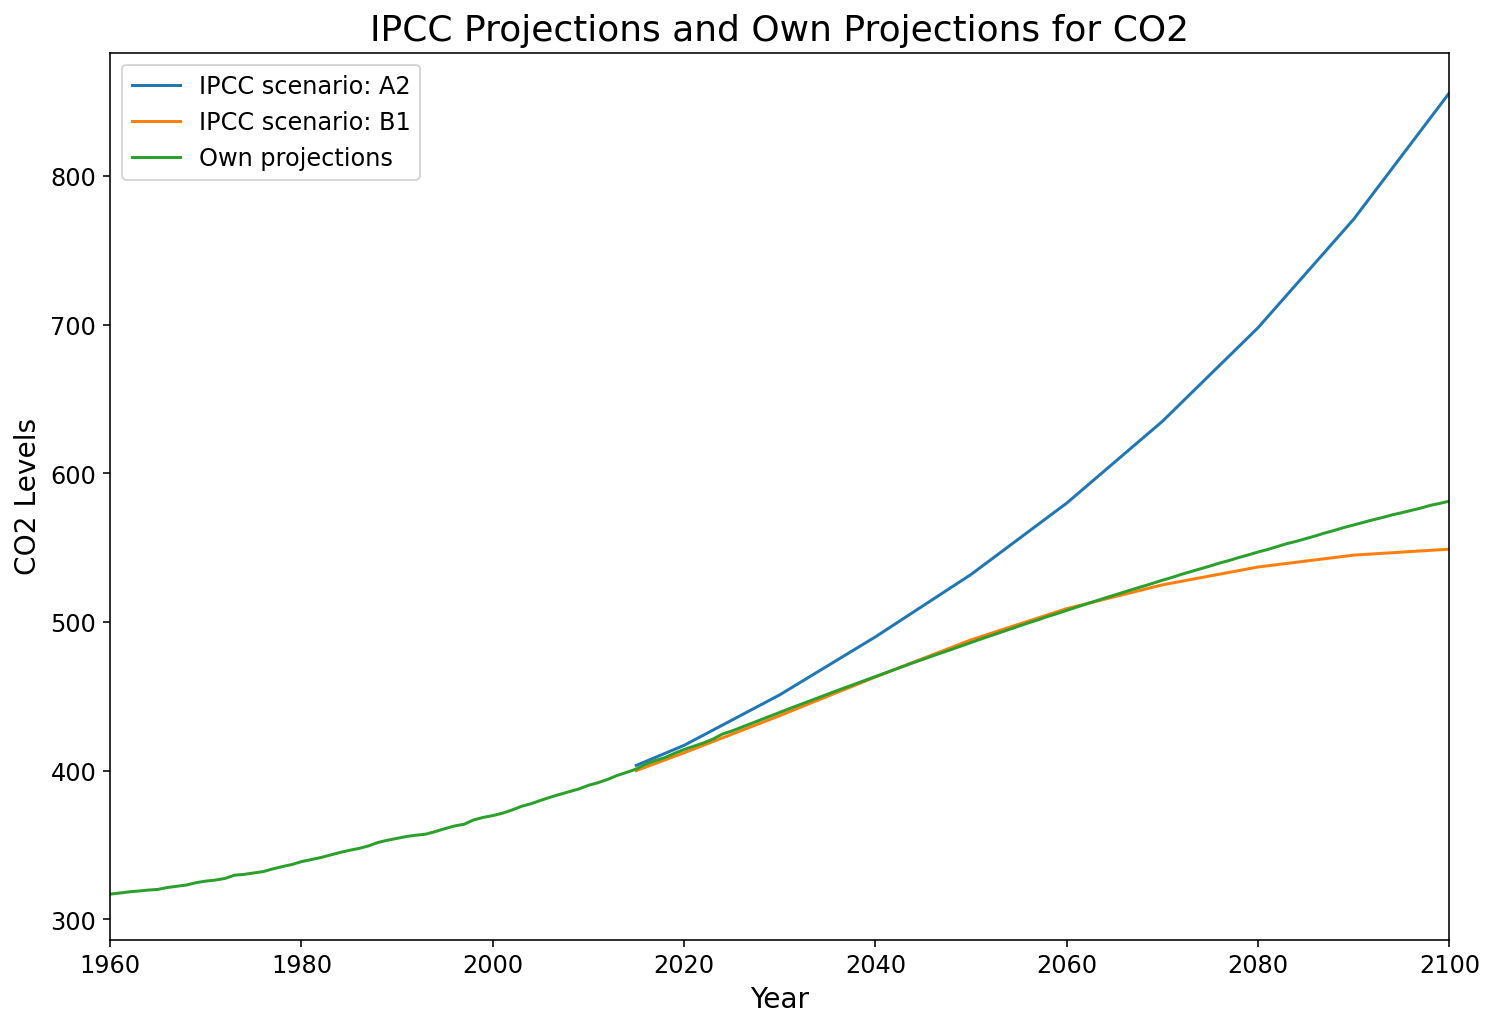

In [34]:
cols_to_plot = scenarios_to_use

fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=True, dpi=144)

for series in cols_to_plot:
    sns.lineplot(x=pred_comparison_df["Year"], y=pred_comparison_df[series], ax=axes,
                 label="IPCC scenario: " + series)

sns.lineplot(x=pred_comparison_df["Year"], y=pred_comparison_df["co2"], ax=axes,
             label="Own projections")

axes.set_xlim(1960, 2100)

# Increase text size
plt.title("IPCC Projections and Own Projections for CO2", fontsize=18)
axes.set_xlabel("Year", fontsize=14)
axes.set_ylabel("CO2 Levels", fontsize=14)
axes.tick_params(axis='both', labelsize=12)
axes.legend(fontsize=12)

plt.show()


In [35]:
# Now we standardize the CO2 scenarios for events and damages
for scenario in scenarios_to_use:
    damage_df_stand[scenario] =  damage_df_stand["d_co2"].copy()
    sea_df_stand[scenario] = sea_df_stand["co2"]

# We train the transformers
transform_co2_d = Standardize().fit(damage_df_stand[scenarios_to_use] )
transform_co2 = Standardize().fit(sea_df_stand[scenarios_to_use] )

# We transform the data
transformed_co2_d = transform_co2_d.transform(ipcc_preds_interpolated[scenarios_to_use] )
transformed_co2_d_df = pd.DataFrame(transformed_co2_d, columns = scenarios_to_use_stand_d)
ipcc_preds_interpolated = pd.merge(ipcc_preds_interpolated,transformed_co2_d_df, left_index=True, right_index=True, how = "left" )

transformed_co2 = transform_co2.transform(ipcc_preds_interpolated[scenarios_to_use] )
transformed_co2_df = pd.DataFrame(transformed_co2, columns = scenarios_to_use_stand)
ipcc_preds_interpolated = pd.merge(ipcc_preds_interpolated,transformed_co2_df, left_index=True, right_index=True, how = "left" )

In [36]:
# Now we introduce the data into the predictions data frames
keys = list(pred_df_stand_dict.keys())

stand_ipcc_list = scenarios_to_use_stand + scenarios_to_use_stand_d

for date in keys:
    for projection in stand_ipcc_list:
        value = ipcc_preds_interpolated.query('Start_Year == @date')[projection].values[0]
        pred_df_stand_dict[date].loc[ : , projection] = value

C:\Users\camil\AppData\Local\Temp\ipykernel_87096\2690971154.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  value = ipcc_preds_interpolated.query('Start_Year == @date')[projection].values[0]
C:\Users\camil\AppData\Local\Temp\ipykernel_87096\2690971154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df_stand_dict[date].loc[ : , projection] = value
C:\Users\camil\AppData\Local\Temp\ipykernel_87096\2690971154.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a

In [41]:
best_loc

{'Vientiane': lat              17.968598
 long            102.644854
 point_number          4135
 Name: 20675, dtype: object,
 'Luang Prabang': lat              19.865814
 long            102.150509
 point_number          8050
 Name: 40250, dtype: object,
 'Savannakhet': lat              16.545687
 long            104.774343
 point_number          2675
 Name: 13375, dtype: object,
 'Pakse': lat              15.122775
 long            105.801061
 point_number           987
 Name: 4935, dtype: object,
 'Thakhek': lat             17.408058
 long            104.81237
 point_number         3541
 Name: 17705, dtype: object}

In [40]:
city_points

{'Vientiane': {'lat': 17.9757, 'long': 102.6331},
 'Luang Prabang': {'lat': 19.886, 'long': 102.135},
 'Savannakhet': {'lat': 16.5575, 'long': 104.7528},
 'Pakse': {'lat': 15.1202, 'long': 105.7987},
 'Thakhek': {'lat': 17.4106, 'long': 104.8304}}

In [37]:
# Now we adjust the features for the model
# Damage 
damage_features_a2 = ['d_Population__standardized',
 'd_log_population_density__standardized',
 'd_log_gdp_per_cap__standardized',
 'd_dev_ocean_temp__standardized',
 'd_co2_A2__standardized',
 'd_precip_deviation__standardized',
 'd_log_gdp_per_cap__standardized__squared']

damage_features_b1 = ['d_Population__standardized',
 'd_log_population_density__standardized',
 'd_log_gdp_per_cap__standardized',
 'd_dev_ocean_temp__standardized',
 'd_co2_B1__standardized',
 'd_precip_deviation__standardized',
 'd_log_gdp_per_cap__standardized__squared']

d_features = [damage_features_a2, damage_features_b1 ]

# Events
features_a2 = ['log_distance_to_river__standardized',
 'log_distance_to_coastline__standardized',
 'Population__standardized',
 'co2_A2__standardized',
 'precip_deviation__standardized',
 'dev_ocean_temp__standardized',
 'log_population_density__standardized',
 'log_gdp_per_cap__standardized',
 'log_gdp_per_cap__standardized__squared',
 'log_population_density__standardized__squared',
 'log_distance_to_river__standardized__squared',
 'log_distance_to_coastline__standardized__squared']

features_b1 = ['log_distance_to_river__standardized',
 'log_distance_to_coastline__standardized',
 'Population__standardized',
 'co2_B1__standardized',
 'precip_deviation__standardized',
 'dev_ocean_temp__standardized',
 'log_population_density__standardized',
 'log_gdp_per_cap__standardized',
 'log_gdp_per_cap__standardized__squared',
 'log_population_density__standardized__squared',
 'log_distance_to_river__standardized__squared',
 'log_distance_to_coastline__standardized__squared']

e_features = [features_a2, features_b1 ]

In [38]:
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data

damage_curves_ipcc_plot = {}

for scenario,e_feature, d_feature,  in zip(scenarios_to_use, e_features, d_features  ):
    damage_curves_ipcc_plot[scenario] = {}
    for year in years:
        
        with pm.Model(coords=coords_predictions) as damage_curves_ipcc_plot[scenario][year]:
            ####################################Events model####################################
            # Set data
            event_features_data = add_data(features= e_feature ,  target = None, df =  pred_df_stand_dict[year],
                                       dims=['obs_idx', 'features'])
            X_gp = pm.Data("X_gp",  pred_df_stand_dict[year][["lat_centered", "long_centered"]].astype(floatX), dims=['obs_idx', 'gp_feature'])
        
            #Flat variables
            country_effect = pm.Flat("country_effect", dims = ["ISO"])    
            beta = pm.Flat("beta", dims = ["event_features"])
            
            # HSGP component
            eta = pm.Flat("eta")
            ell = pm.Flat("ell", dims=["gp_feature"])
            cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
        
            m0, m1, c = 35, 35, 1.5
            gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
            gp._X_center = compute_center( pred_df_stand_dict[year][["lat_centered", "long_centered"]].values.astype(floatX))
        
            phi, sqrt_psd = gp.prior_linearized(X=X_gp)
        
            basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)
        
            HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
        
            # Event model components
            event_features_component = pm.Deterministic('event_features_component', 
                                                        event_features_data @ beta, dims=['obs_idx'])
    
            event_features_component_inv_logit = pm.Deterministic('event_features_component_inv_logit', 
                                               pm.math.invlogit(event_features_component))
    
            HSGP_component_inv_logit = pm.Deterministic('HSGP_component_inv_logit', 
                                                       pm.math.invlogit(HSGP_component))
            
            logit_p = pm.Deterministic('logit_p', country_effect[ISO_idx_laos] + event_features_component 
                                       + HSGP_component, dims=['obs_idx'])
            event_prob_y_hat = pm.Deterministic('event_prob_y_hat', pm.math.invlogit(logit_p), dims=['obs_idx'])
        
            ####################################Damages model####################################
            # Set data
            damage_x_data = pm.Data("damage_x_data",   pred_df_stand_dict[year][d_feature], dims=['obs_idx', 'damage_features'])
        
            # Set flats
            country_effect_damage = pm.Flat("country_effect_damage", dims = ["ISO_damage"])
            betas_damage = pm.Flat("betas_damage", dims = ["damage_features"])
            sigma_damage = pm.Flat("sigma_damage")
        
            #Damage model components
            mu =  country_effect_damage[ISO_damage_idx_laos] + damage_x_data @ betas_damage
           
            ln_damage_millions = pm.Normal("ln_damage_millions", mu = mu, sigma = sigma_damage , dims = ["obs_idx"])
        
            damage_millions = pm.Deterministic("damage_millions", pm.math.exp(ln_damage_millions), dims=['obs_idx'])
        
            # # #################################### Damage curves ####################################
            damages_curves = pm.Deterministic("damages_curves", damage_millions * event_prob_y_hat, dims=['obs_idx'])

In [39]:
# Sample predictions
idata_ippc_plot_point = {}

for scenario in scenarios_to_use:
    idata_ippc_plot_point[scenario] = {}
    for year in years:
        if exists (here(f"notebooks/geo_damage_model/damage_curves_ipcc_{scenario}_{year}.idata")):
            idata_ippc_plot_point[scenario][year] = az.from_netcdf(here(f"notebooks/geo_damage_model/damage_curves_ipcc_{scenario}_{year}.idata"))
                                                
        else:                                  
            with freeze_dims_and_data(damage_curves_ipcc_plot[scenario][year] ):
                idata_ippc_plot_point[scenario][year] = pm.sample_posterior_predictive(merged_posteriors , extend_inferencedata=False, 
                                                                  compile_kwargs={'mode':'JAX'},
                                                            var_names=[
                                                                      'event_features_component_inv_logit',
                                                                      'HSGP_component_inv_logit',
                                                                       'HSGP_component', 
                                                                       'event_features_component', 
                                                                       'logit_p', 
                                                                       'event_prob_y_hat', 
                                                                       "ln_damage_millions",
                                                                        "damage_millions", 
                                                                       "damages_curves"
                                                                      ])
                # az.to_netcdf(data = idata_ippc_plot_point[scenario][year],
                #              filename= pathlib.Path(here(f"notebooks/geo_damage_model/damage_curves_ipcc_{scenario}_{year}.idata")))

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2AD15763A00>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ln_damage_millions]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2AD13471700>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ln_damage_millions]


Output()


KeyboardInterrupt



### Country curves

In [ ]:
years_short = years

n = len(years_short)
fig, axes = plt.subplots(n, 2, figsize=(12, 2.5 * n) , sharex=True)  # (rows, cols)

for scenario, b in zip(scenarios_to_use , [0,1]):
    for year, m in zip(years_short, range(0, n+1)):
        az.plot_posterior(idata_ippc_plot_point[scenario][year].posterior_predictive,
                          var_names= ["damages_curves"], 
                         ax = axes[m,b],
                         hdi_prob = 0.75)
        axes[m,b].set_xlim(0, 50) 
        axes[m,b].set_title(f"IPPC scenario {scenario}, year:  {year[:4]}" )
    
    for a in [0,1]:
        axes[a,b].xaxis.set_visible(False) # Remove tick labels  
        axes[a,b].xaxis.set_visible(False) 
        
    plt.suptitle( "Damage curves Laos different IPCC scenarios")
    plt.tight_layout()

# Modeling the removal construction of flood walls

For this exercise, we select two points: 
- Vientiane: The capital is located along the Mekong River and has experienced several major floods in the past. One of the most severe occurred in 2008.
- Pakse: Situated on the Mekong River in southern Laos. Pakse has experienced seasonal flooding, particularly during heavy monsoons, with significant events recorded in 2013 and 2019.

We modify the distance to river 

In [95]:
pred_df_stand_dict["2026-01-01"].query('point_number == 987')["log_distance_to_river__standardized"]

4935   -1.022788
Name: log_distance_to_river__standardized, dtype: float64

In [152]:
# define loop variables
wall_cities = ["Vientiane", "Savannakhet"]
river_variables = ["log_distance_to_river__standardized", "log_distance_to_river__standardized__squared"]
wall_variables = [x + "_wall" for x in river_variables]
max_river_0 = pred_df_stand_dict["2026-01-01"]["log_distance_to_river__standardized"].max()
max_river_1 = pred_df_stand_dict["2026-01-01"]["log_distance_to_river__standardized__squared"].max()

index_val = {}
city_pred_data = {}

# create the new distance to river variables
for city in wall_cities:
    index_val[city] = {}
    city_pred_data[city] = {}
    for year in years:
        # log_distance_to_river__standardized
        pred_df_stand_dict[year].loc[ : ,  wall_variables[0] ] = pred_df_stand_dict[year].loc[ : , "log_distance_to_river__standardized" ]
        pred_df_stand_dict[year].loc[ : ,  wall_variables[1] ] = pred_df_stand_dict[year].loc[ : , "log_distance_to_river__standardized__squared" ]
        
        point_num = best_loc[city].loc["point_number"]
        index_val[city][year] = pred_df_stand_dict[year].query('point_number == @point_num').index.values[0]
        
        # Re-write the values
        pred_df_stand_dict[year].loc[index_val[city][year], wall_variables[0] ] = max_river_0

        # log_distance_to_river__standardized__squared
        pred_df_stand_dict[year].loc[index_val[city][year], wall_variables[1] ] = max_river_1

        # Store the city values
        city_pred_data[city][year] =  pred_df_stand_dict[year].loc[index_val[city][year], : ]
        
    city_pred_data[city] = pd.DataFrame(city_pred_data[city]).T

In [153]:
# Define the wall features
event_features_wall =event_features.copy()
event_features_wall[-2] = "log_distance_to_river__standardized_wall"
event_features_wall[-1] = "log_distance_to_river__standardized__squared_wall"

In [154]:
damage_curves_walls = {}

for year in years:
    with pm.Model(coords=coords_predictions) as damage_curves_walls[year]:
        ####################################Events model####################################
        # Set data
        event_features_data = add_data(features= event_features_wall ,  target = None, df = pred_df_stand_dict[year],
                                   dims=['obs_idx', 'features'])
        X_gp = pm.Data("X_gp",  pred_df_stand_dict[year][["lat_centered", "long_centered"]].astype(floatX), dims=['obs_idx', 'gp_feature'])
    
        #Flat variables
        country_effect = pm.Flat("country_effect", dims = ["ISO"])    
        beta = pm.Flat("beta", dims = ["event_features"])
        
        # HSGP component
        eta = pm.Flat("eta")
        ell = pm.Flat("ell", dims=["gp_feature"])
        cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    
        m0, m1, c = 35, 35, 1.5
        gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
        gp._X_center = compute_center( pred_df_stand_dict[year][["lat_centered", "long_centered"]].values.astype(floatX))
    
        phi, sqrt_psd = gp.prior_linearized(X=X_gp)
    
        basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)
    
        HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    
        # Event model components
        event_features_component = pm.Deterministic('event_features_component', 
                                                    event_features_data @ beta, dims=['obs_idx'])

        event_features_component_inv_logit = pm.Deterministic('event_features_component_inv_logit', 
                                           pm.math.invlogit(event_features_component))

        HSGP_component_inv_logit = pm.Deterministic('HSGP_component_inv_logit', 
                                                   pm.math.invlogit(HSGP_component))
        
        logit_p = pm.Deterministic('logit_p', country_effect[ISO_idx_laos] + event_features_component 
                                   + HSGP_component, dims=['obs_idx'])
        event_prob_y_hat = pm.Deterministic('event_prob_y_hat', pm.math.invlogit(logit_p), dims=['obs_idx'])
    
        ####################################Damages model####################################
        # Set data
        damage_x_data = pm.Data("damage_x_data",   pred_df_stand_dict[year][d_feature], dims=['obs_idx', 'damage_features'])
    
        # Set flats
        country_effect_damage = pm.Flat("country_effect_damage", dims = ["ISO_damage"])
        betas_damage = pm.Flat("betas_damage", dims = ["damage_features"])
        sigma_damage = pm.Flat("sigma_damage")
    
        #Damage model components
        mu =  country_effect_damage[ISO_damage_idx_laos] + damage_x_data @ betas_damage
       
        ln_damage_millions = pm.Normal("ln_damage_millions", mu = mu, sigma = sigma_damage , dims = ["obs_idx"])
    
        damage_millions = pm.Deterministic("damage_millions", pm.math.exp(ln_damage_millions), dims=['obs_idx'])
    
        # # #################################### Damage curves ####################################
        damages_curves = pm.Deterministic("damages_curves", damage_millions * event_prob_y_hat, dims=['obs_idx'])

In [155]:
# Sample predictions
idata_wall_plot_point = {}
for year in years:
    if exists(here(f"/notebooks/geo_damage_model/damage_curves_walls_{year}.idata")):
        idata_wall_plot_point[year] = az.from_netcdf(here(f"/notebooks/geo_damage_model/damage_curves_walls_{year}.idata"))
                                                
    else:                                  
        with freeze_dims_and_data(damage_curves_walls[year] ):
            idata_wall_plot_point[year] = pm.sample_posterior_predictive(merged_posteriors , extend_inferencedata=False, 
                                                              compile_kwargs={'mode':'JAX'},
                                                        var_names=[
                                                                  'event_features_component_inv_logit',
                                                                  'HSGP_component_inv_logit',
                                                                   'HSGP_component', 
                                                                   'event_features_component', 
                                                                   'logit_p', 
                                                                   'event_prob_y_hat', 
                                                                   "ln_damage_millions",
                                                                    "damage_millions", 
                                                                   "damages_curves"
                                                                  ])
            az.to_netcdf(data = idata_wall_plot_point[year], filename= pathlib.Path(here(f"notebooks/geo_damage_model/damage_curves_walls_{year}.idata")))

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x255A96A6260>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ln_damage_millions]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x255F6AE3060>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ln_damage_millions]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x255F73DFE60>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ln_damage_millions]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x255A7CE3220>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ln_damage_millions]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x255AA25A500>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ln_damage_millions]


Output()

In [100]:
# We built the city projections idata
city_predictions_wall = {}

for city in wall_cities:
    city_predictions_wall[city] = {}
    for year in years:
        city_predictions_wall[city][year] =  idata_wall_plot_point[year].sel(obs_idx = best_loc[city]["point_number"] )


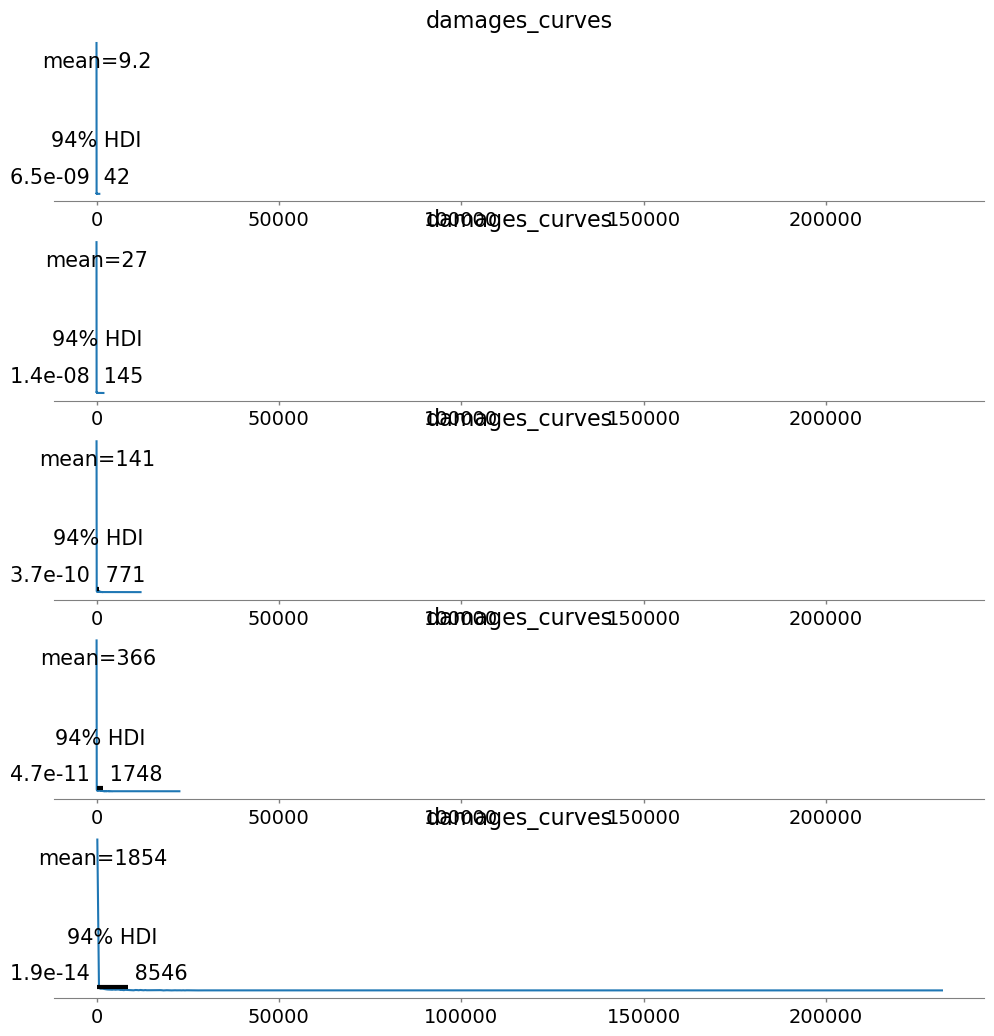

In [104]:
fig, axes = plt.subplots(n, 1, figsize=(12, 2.5 * n), sharex=True)  # (rows, cols)
for year, m in zip(years_short, range(n)):
    az.plot_posterior(
                city_predictions_wall["Savannakhet"][year].posterior_predictive ,
                var_names=["damages_curves"],
                ax=axes[m],
                hdi_prob=None  
            )

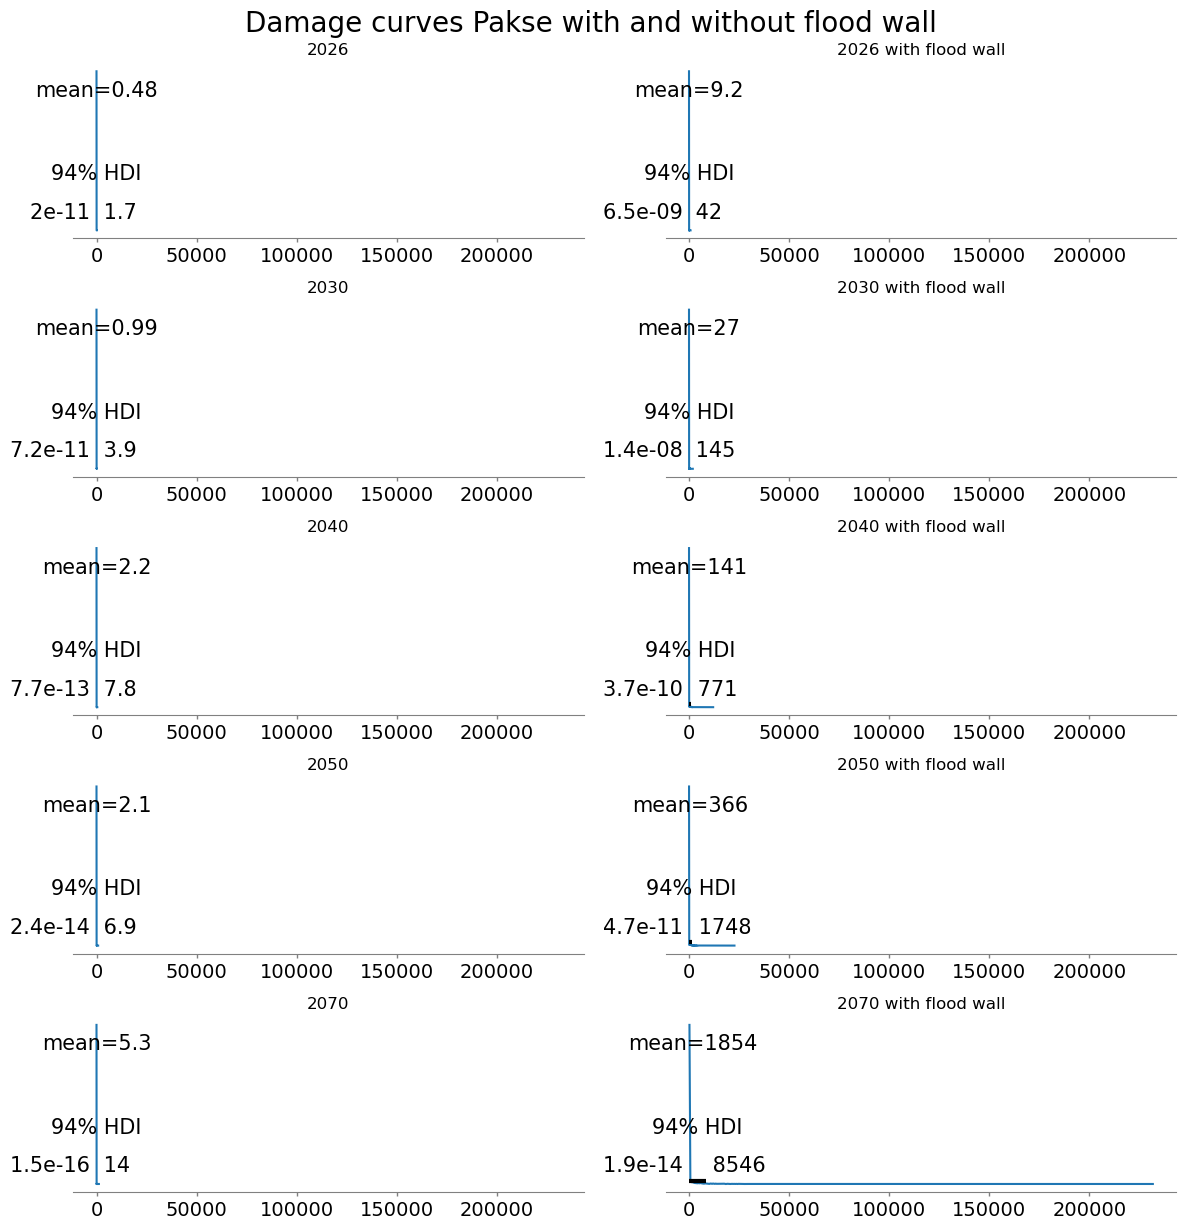

In [105]:
city = "Pakse"
years_short = years

titles = ["", " with flood wall"]
predictions = [city_predictions, city_predictions_wall]

n = len(years_short)
fig, axes = plt.subplots(n, 2, figsize=(12, 2.5 * n), sharex=True)  # (rows, cols)

for prediction, b in zip(predictions, [0,1]):
    for year, m in zip(years_short, range(n)):
        az.plot_posterior(
            prediction[city][year].posterior_predictive,  # 
            var_names=["damages_curves"],
            ax=axes[m, b],
            hdi_prob=None  
        )
        # axes[m, b].set_xlim(0, 2)
        axes[m, b].set_title(str(year[:4]) + titles[b])

plt.suptitle(f"Damage curves {city} with and without flood wall", size = 20)
plt.tight_layout()
plt.show()


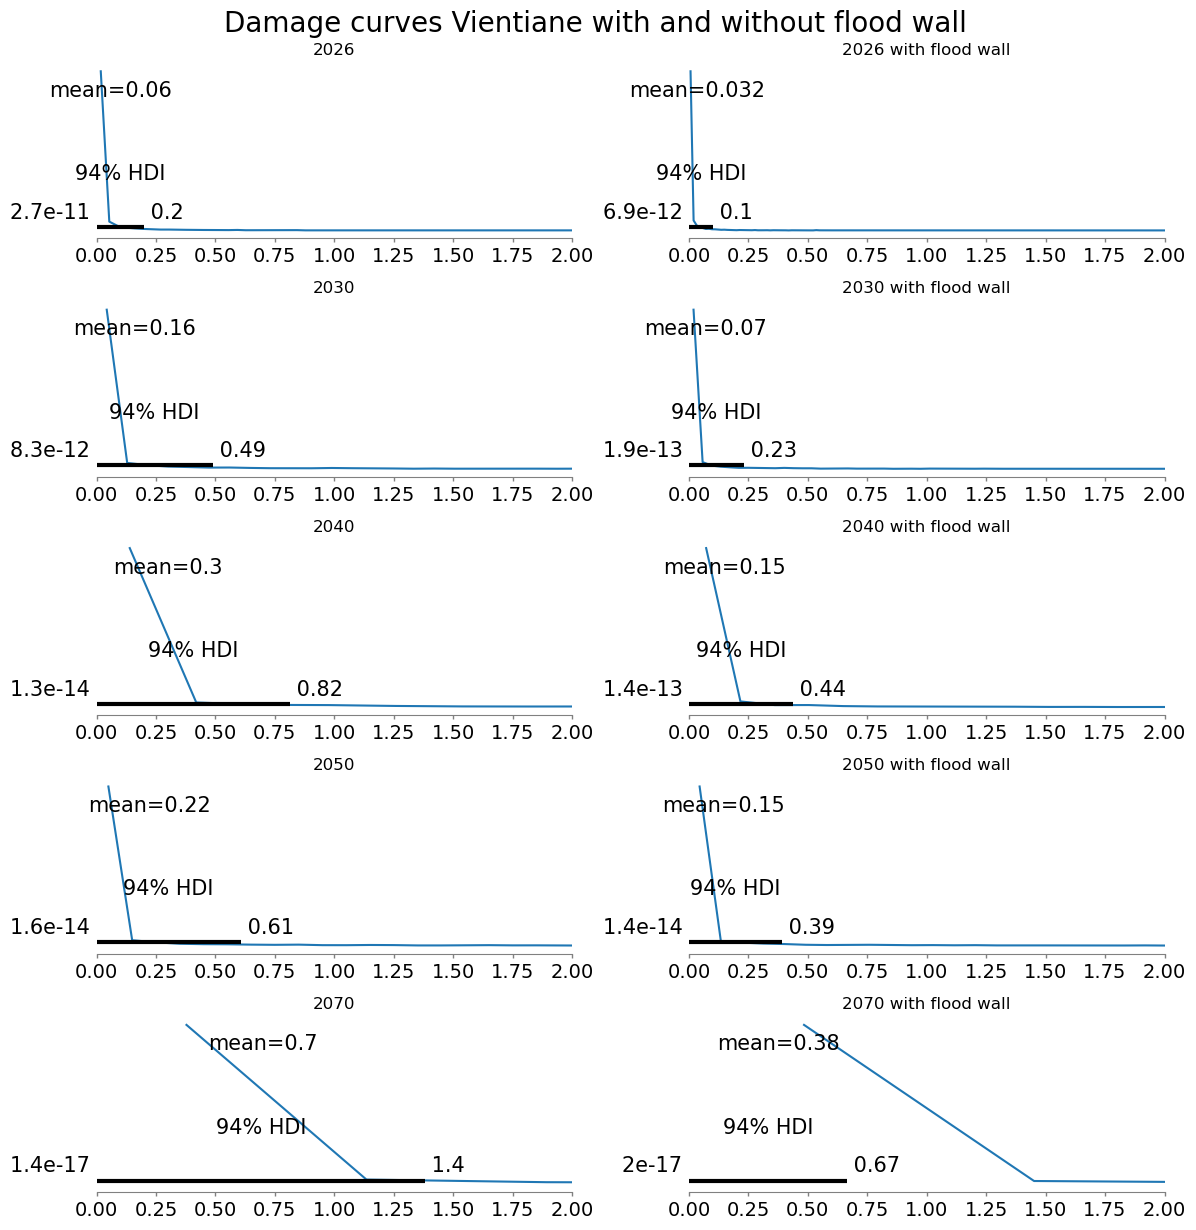

In [103]:
city = "Vientiane"
years_short = years

titles = ["", " with flood wall"]
predictions = [city_predictions, city_predictions_wall]

n = len(years_short)
fig, axes = plt.subplots(n, 2, figsize=(12, 2.5 * n), sharex=True)  # (rows, cols)

for prediction, b in zip(predictions, [0,1]):
    for year, m in zip(years_short, range(n)):
        az.plot_posterior(
            prediction[city][year].posterior_predictive,  # ✅ Correct dataset
            var_names=["damages_curves"],
            ax=axes[m, b],
            hdi_prob=None  
        )
        axes[m, b].set_xlim(0, 2)
        axes[m, b].set_title(str(year[:4]) + titles[b])

plt.suptitle(f"Damage curves {city} with and without flood wall", size = 20)
plt.tight_layout()
plt.show()


In [87]:
from scipy import stats
from scipy.optimize import root_scalar

def obj(x, RY, sf):
    return 1 / max(sf(x), np.spacing(1)) - RY


# sample trace data from a known distribution
d = stats.gamma(a=2, scale=1/10)
fake_idata = d.rvs((6, 1000))

sf = stats.ecdf(fake_idata.ravel()).sf.evaluate

res = root_scalar(obj, bracket = [fake_idata.min(), fake_idata.max()], args=(100, sf), method='brentq')

print(res.root)
print(d.ppf(0.99))

0.654641112173109
0.6638352067993811


In [80]:
from scipy.stats import scipy_ecdf
sf = scipy_ecdf( .values.ravel()).sf.evaluate

In [82]:
from scipy.stats import ECDF

# Flatten the posterior predictive values
damage_values = prediction[city][year].posterior_predictive["damages_curves"].values.ravel()

# Compute ECDF
ecdf = ECDF(damage_values)

# Evaluate ECDF at a given point x
x = 0.5  # Example value
sf = 1 - ecdf(x)  # Survival function (1 - CDF)


ImportError: cannot import name 'ECDF' from 'scipy.stats' (C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\scipy\stats\__init__.py)

In [83]:
import scipy
print(scipy.__version__)


1.12.0
